# Introduction to `linopy`

:::{note}
This material is in part adapted from the following resources:
- [Linopy Getting Started](https://linopy.readthedocs.io/en/latest/index.html)
- [PyPSA simple electricity market examples](https://pypsa.readthedocs.io/en/latest/examples/simple-electricity-market-examples.html)
:::

<img src="https://github.com/PyPSA/linopy/blob/master/doc/logo.png?raw=true" width="300px" />

[Linopy](https://linopy.readthedocs.io/en/latest/index.html)  is an open-source framework for formulating, solving, and analyzing optimization problems with Python.

With Linopy, you can create optimization models within Python that consist of decision variables, constraints, and optimization objectives. You can then solve these instances using a variety of commercial and open-source solvers (specialised software).

[Linopy](https://linopy.readthedocs.io/en/latest/index.html) supports a wide range of problem types, including:

- **Linear programming**
- Integer programming
- Mixed-integer programming
- Quadratic programming


:::{note}
Documentation for this package is available at https://linopy.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas linopy highspy
```
:::

## Solve a Basic Model

In this example, we explain the basic functions of the linopy Model class. First, we are setting up a very simple linear optimization model, given by

Minimize:
    $$x + 2y$$
subject to:
    $$ x \ge 0 $$
    $$y \ge 0 $$
    $$3x + 7y \ge 10 $$
    $$5x + 2y \ge 3 $$

### Initializing a `Model`

The Model class in Linopy is a fundamental part of the library. It serves as a container for all the relevant data associated with a linear optimization problem. This includes variables, constraints, and the objective function.

In [1]:
import linopy
import numpy as np

m = linopy.Model()

This creates a new Model object, which you can then use to define your optimization problem.

### Adding variables

Variables in a linear optimization problem represent the decision variables. A variable can always be assigned with a lower and an upper bound. In our case, both `x` and `y` have a lower bound of zero (default is unbouded). In Linopy, you can add variables to a Model using the `add_variables` method:

In [2]:
x = m.add_variables(lower=0, name="x")
y = m.add_variables(lower=0, name="y");

`x` and `y` are linopy variables of the class `linopy.Variable`. Each of them contain all relevant information that define it. The `name` parameter is optional but can be useful for referencing the variables later.

In [3]:
x

Variable
--------
x ∈ [0, inf]

### Adding Constraints

Constraints define the feasible region of the optimization problem. They consist of the left hand side (lhs) and the right hand side (rhs). The first constraint that we want to write down is $3x + 7y = 10$ which we write out exactly in the mathematical way:

In [4]:
3 * x + 7 * y >= 10

Constraint (unassigned)
-----------------------
+3 x + 7 y ≥ 10.0

Note, we can also mix the constant and the variable expression, like this

In [5]:
3 * x + 7 * y - 10 >= 0

Constraint (unassigned)
-----------------------
+3 x + 7 y ≥ 10.0

… and linopy will automatically take over the separation of variables expression on the lhs, and constant values on the rhs.

The constraint is currently not assigned to the model. We assign it by calling the function `m.add_constraints`

In [6]:
m.add_constraints(3 * x + 7 * y >= 10)
m.add_constraints(5 * x + 2 * y >= 3);

### Adding the Objective 

The objective function defines what you want to optimize. You can set the objective function of a Model in Linopy using the add_objective method. For our example that would be

In [7]:
m.add_objective(x + 2 * y, sense="min")

Note, we can either minimize or maximize in Linopy. Per default, Linopy applies `sense='min'` making it not necessary to explicitly define the optimization sense.

### Solving the Model

Once you've defined your Model with variables, constraints, and an objective function, you can solve it using the `solve` method:

In [8]:
m.solve()

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\huang\AppData\Local\Temp\linopy-problem-tdgo97kt.lp
Reading time = 0.00 seconds
obj: 2 rows, 2 columns, 4 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x4c5ee539
Coefficient statistics:
  Matrix range     [2e+00, 7e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.625000e+00   0.000000e+00      0s
       2    2.8620690e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds (0.00 work un

('ok', 'optimal')

The solution of the linear problem assigned to the variables under `solution` in form of a `xarray.Dataset`.

In [9]:
x.solution

<xarray.DataArray 'solution' ()>
array(0.03448276)

In [10]:
y.solution

<xarray.DataArray 'solution' ()>
array(1.4137931)

Well done! You solved your first linopy model!

## Use Coordinates

Now, the real power of the package comes into play! 

Linopy is structured around the concept that variables, and therefore expressions and constraints, have coordinates. That is, a `Variable` object actually contains multiple variables across dimensions, just as we know it from a `numpy` array or a `pandas.DataFrame`.

Suppose the two variables `x` and `y` are now functions of time `t` and we would modify the problem according to: 

Minimize:
$$\sum_t x_t + 2 y_t$$

subject to:

$$x_t \ge 0 \qquad \forall t $$
$$y_t \ge 0 \qquad \forall t $$
$$3x_t + 7y_t \ge 10 t \qquad \forall t$$
$$5x_t + 2y_t \ge 3 t \qquad \forall t$$

whereas `t` spans all the range from 0 to 10.

In order to formulate the new problem with linopy, we start again by initializing a model.

In [11]:
m = linopy.Model()

Again, we define `x` and `y` using the `add_variables` function, but now we are adding a `coords` argument. This automatically creates optimization variables for all coordinates, in this case time-steps.

In [12]:
import pandas as pd

time = pd.Index(range(10), name="time")

x = m.add_variables(
    lower=0,
    coords=[time],
    name="x",
)
y = m.add_variables(lower=0, coords=[time], name="y")

Following the previous example, we write the constraints out using the syntax from above, while multiplying the rhs with `t`. Note that the coordinates from the lhs and the rhs have to match. 

.. note::
    In the beginning, it is recommended to use explicit dimension names. Like that, things remain clear and no unexpected broadcasting (which we show later) will happen. 

In [13]:
factor = pd.Series(time, index=time)

3 * x + 7 * y >= 10 * factor

Constraint (unassigned) (time: 10):
-----------------------------------
[0]: +3 x[0] + 7 y[0] ≥ -0.0
[1]: +3 x[1] + 7 y[1] ≥ 10.0
[2]: +3 x[2] + 7 y[2] ≥ 20.0
[3]: +3 x[3] + 7 y[3] ≥ 30.0
[4]: +3 x[4] + 7 y[4] ≥ 40.0
[5]: +3 x[5] + 7 y[5] ≥ 50.0
[6]: +3 x[6] + 7 y[6] ≥ 60.0
[7]: +3 x[7] + 7 y[7] ≥ 70.0
[8]: +3 x[8] + 7 y[8] ≥ 80.0
[9]: +3 x[9] + 7 y[9] ≥ 90.0

It always helps to write out the constraints before adding them to the model. Since they look good, let's assign them.

In [14]:
con1 = m.add_constraints(3 * x + 7 * y >= 10 * factor, name="con1")
con2 = m.add_constraints(5 * x + 2 * y >= 3 * factor, name="con2")
m

Linopy LP model

Variables:
----------
 * x (time)
 * y (time)

Constraints:
------------
 * con1 (time)
 * con2 (time)

Status:
-------
initialized

Now, when it comes to the objective, we use the `sum` function of `linopy.LinearExpression`. This stacks all terms all terms of the `time` dimension and writes them into one big expression. 

In [15]:
obj = (x + 2 * y).sum()
m.add_objective(obj)

In [16]:
m.solve()

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\huang\AppData\Local\Temp\linopy-problem-fs1daa3m.lp
Reading time = 0.00 seconds
obj: 20 rows, 20 columns, 40 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x3434cd3b
Coefficient statistics:
  Matrix range     [2e+00, 7e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 9e+01]
Presolve removed 2 rows and 2 columns
Presolve time: 0.01s
Presolved: 18 rows, 18 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.312500e+01   0.000000e+00      0s
      18    1.2879310e+02   0.000000e+00   0.000000e+00      0s

Solved

('ok', 'optimal')

In order to inspect the solution. You can go via the variables, i.e. `y.solution` or via the `solution` aggregator of the model, which combines the solution of all variables. This can sometimes be helpful.

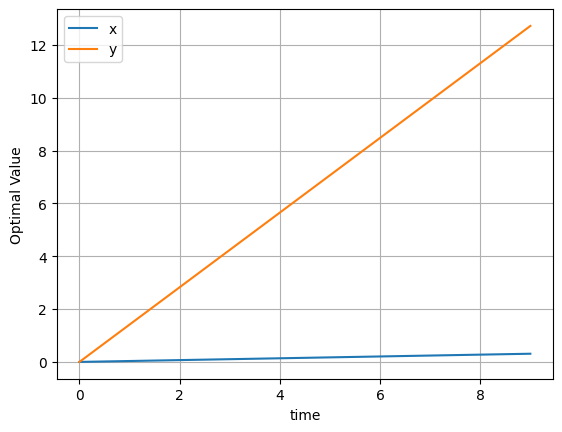

In [17]:
m.solution.to_dataframe().plot(grid=True, ylabel="Optimal Value");

Alright! Now you learned how to set up linopy variables and expressions with coordinates. For more advanced `linopy` operations you can check out the [User Guide](https://linopy.readthedocs.io/en/latest/user-guide.html).

## Electricity Market Examples

### Single bidding zone, single period

We want to minimise operational cost of an example electricity system representing South Africa subject to generator limits and meeting the load:

\begin{equation}
    \min_{g_s} \sum_s o_s g_s
  \end{equation}
  such that
  \begin{align}
    g_s &\leq G_s \\
    g_s &\geq 0 \\
    \sum_s g_s &= d
  \end{align}

We are given the following information on the South African electricity system:

Marginal costs in EUR/MWh

In [18]:
marginals_df = pd.DataFrame(
    {"Generator": ["Wind", "Coal", "Gas", "Oil"], "MarginalCost": [0, 30, 60, 80]}
)

Power plant capacities in MW

In [19]:
capacities_df = pd.DataFrame(
    {"Generator": ["Wind", "Coal", "Gas", "Oil"], "Capacity": [3000, 35000, 8000, 2000]}
)

Inelastic demand in MW

In [20]:
load = 42000

We now start building the model

In [21]:
m = linopy.Model()

Let's define the dispatch variables `g` with the `lower` and `upper` bound:
$$g_s \leq G_s $$
$$g_s \geq 0 $$

In [22]:
g = m.add_variables(
    lower=0, upper=capacities_df.Capacity, coords=[capacities_df.Generator], name="g"
)
g

Variable (dim_0: 4)
-------------------
[Wind]: g[Wind] ∈ [0, 3000]
[Coal]: g[Coal] ∈ [0, 3.5e+04]
[Gas]: g[Gas] ∈ [0, 8000]
[Oil]: g[Oil] ∈ [0, 2000]

And and the objective:
$$\min_{g_s} \sum_s o_s g_s$$

In [23]:
m.add_objective(marginals_df.MarginalCost.values * g, sense="min")
m.objective

Objective:
----------
LinearExpression: +0 g[Wind] + 30 g[Coal] + 60 g[Gas] + 80 g[Oil]
Sense: min
Value: None

Which is subject to: 

$$\sum_s g_s = d$$

In [24]:
m.add_constraints(g.sum() == load, name="energy_balance")

Constraint `energy_balance`
---------------------------
+1 g[Wind] + 1 g[Coal] + 1 g[Gas] + 1 g[Oil] = 42000.0

It always helps to write out the constraints before adding them to the model. Since they look good, let’s assign them.

In [25]:
m.solve()

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\huang\AppData\Local\Temp\linopy-problem-0xergcyl.lp
Reading time = 0.00 seconds
obj: 1 rows, 4 columns, 4 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9b6e654b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 8e+01]
  Bounds range     [2e+03, 4e+04]
  RHS range        [4e+04, 4e+04]
Presolve removed 1 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2900000e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.290

('ok', 'optimal')

This is the optimimal generator dispatch (MW)

In [26]:
m.solution.to_dataframe()

,g
dim_0,
Wind,3000.0
Coal,35000.0
Gas,4000.0
Oil,0.0


And the market clearing price we can read from the shadow price of the energy balance constraint (i.e. the added cost of increasing electricity demand by one unit):

In [27]:
m.dual["energy_balance"].item()

60.0

### Two bidding zones with transmission

Let's add a spatial dimension, such that the optimisation problem is expanded to
\begin{equation}
  \min_{g_{i,s}, f_\ell} \sum_s o_{i,s} g_{i,s}
\end{equation}
such that
\begin{align}
  g_{i,s} &\leq G_{i,s} \\
  g_{i,s} &\geq 0 \\
  \sum_s g_{i,s} - \sum_\ell K_{i\ell} f_\ell &= d_i & \text{KCL} \\
  |f_\ell| &\leq F_\ell & \text{line limits}  \\
  \sum_\ell C_{\ell c} x_\ell f_\ell &= 0 & \text{KVL} 
\end{align}

In this example, we connect the previous South African electricity system with a hydro generation unit in Mozambique through a single transmission line. Note that because a single transmission line will not result in any cycles, we can neglect KVL in this case.

We are given the following data (all in MW):

In [28]:
generators = ["Coal", "Wind", "Gas", "Oil", "Hydro"]
countries = ["South_Africa", "Mozambique"]

capacities_df = pd.DataFrame(
    {
        "Coal": [35000, 0],
        "Wind": [3000, 0],
        "Gas": [8000, 0],
        "Oil": [2000, 0],
        "Hydro": [0, 1200],
    },
    index=countries,
)

In [29]:
capacities_df

,Coal,Wind,Gas,Oil,Hydro
South_Africa,35000,3000,8000,2000,0
Mozambique,0,0,0,0,1200


In [30]:
marginal_series = pd.Series([30, 0, 60, 80, 0], index=generators)
marginal_series

Coal     30
Wind      0
Gas      60
Oil      80
Hydro     0
dtype: int64

In [31]:
loads_series = pd.Series([42000, 650], index=countries)
loads_series

South_Africa    42000
Mozambique        650
dtype: int64

In [32]:
transmission = 500

Let's start with a new model instance

In [33]:
m = linopy.Model()

Now we create dispatch variables, as before, with the `upper` and `lower` bound for each countries and generators.

In [34]:
contries_index = pd.Index(countries, name='countries')
generators_index=pd.Index(generators, name='generators')

In [35]:
g=m.add_variables(lower=0, upper=capacities_df, coords=[contries_index,generators_index], name='g')
g

Variable (countries: 2, generators: 5)
--------------------------------------
[South_Africa, Coal]: g[South_Africa, Coal] ∈ [0, 3.5e+04]
[South_Africa, Wind]: g[South_Africa, Wind] ∈ [0, 3000]
[South_Africa, Gas]: g[South_Africa, Gas] ∈ [0, 8000]
[South_Africa, Oil]: g[South_Africa, Oil] ∈ [0, 2000]
[South_Africa, Hydro]: g[South_Africa, Hydro] ∈ [0, 0]
[Mozambique, Coal]: g[Mozambique, Coal] ∈ [0, 0]
[Mozambique, Wind]: g[Mozambique, Wind] ∈ [0, 0]
[Mozambique, Gas]: g[Mozambique, Gas] ∈ [0, 0]
[Mozambique, Oil]: g[Mozambique, Oil] ∈ [0, 0]
[Mozambique, Hydro]: g[Mozambique, Hydro] ∈ [0, 1200]

We now define the line limit for the transmission line, assuming that power flowing from Mozambique	to South Africa is positive.

The line limit equation can be defined as   
\begin{align}
|f_\ell| &\leq F_\ell & \text{line limits}
\end{align}

In [36]:
f_line=m.add_variables(lower=-1*transmission, upper=transmission,name="line_limit")
f_line

Variable
--------
line_limit ∈ [-500, 500]

We define the Kirchhoff's current law (KCL) constraint. The KCL equation can be defined as:
\begin{align}
  \sum_s g_{i,s} - \sum_\ell K_{i\ell} f_\ell &= d_i & \text{KCL} \\
\end{align}

In [37]:
m.add_constraints(g.loc["South_Africa",:].sum() + f_line == loads_series.loc["South_Africa"],name="South_Africa_KCL")

Constraint `South_Africa_KCL`
-----------------------------
+1 g[South_Africa, Coal] + 1 g[South_Africa, Wind] + 1 g[South_Africa, Gas] + 1 g[South_Africa, Oil] + 1 g[South_Africa, Hydro] + 1 line_limit = 42000.0

In [38]:
m.add_constraints(g.loc["Mozambique",:].sum() - f_line == loads_series.loc["Mozambique"],name="Mozambique_KCL")

Constraint `Mozambique_KCL`
---------------------------
+1 g[Mozambique, Coal] + 1 g[Mozambique, Wind] + 1 g[Mozambique, Gas] + 1 g[Mozambique, Oil] + 1 g[Mozambique, Hydro] - 1 line_limit = 650.0

The objective can be written as:
$$\min_{g_{i,s}, f_\ell} \sum_s o_{i,s} g_{i,s}$$

In [39]:
obj=(g.loc["South_Africa",:] * marginal_series).sum() + (g.loc["Mozambique",:] * marginal_series).sum()
obj

LinearExpression
----------------
+30 g[South_Africa, Coal] + 0 g[South_Africa, Wind] + 60 g[South_Africa, Gas] ... +60 g[Mozambique, Gas] + 80 g[Mozambique, Oil] + 0 g[Mozambique, Hydro]

In [40]:
m.add_objective(obj,sense="min")

We now solve the model.

In [41]:
m.solve()

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\huang\AppData\Local\Temp\linopy-problem-_4hpgkd6.lp
Reading time = 0.00 seconds
obj: 2 rows, 11 columns, 12 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 11 columns and 12 nonzeros
Model fingerprint: 0xfe77df65
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 8e+01]
  Bounds range     [5e+02, 4e+04]
  RHS range        [7e+02, 4e+04]
Presolve removed 2 rows and 11 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2600000e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  

('ok', 'optimal')

Now, we print the optimization results

In [42]:
results_South_Africa = dict(
    zip(generators, g.loc["South_Africa",:].solution.values)
)
print("South Africa: ", results_South_Africa)

South Africa:  {'Coal': 35000.0, 'Wind': 3000.0, 'Gas': 3500.0, 'Oil': 0.0, 'Hydro': 0.0}


In [43]:
results_Mozambique = dict(
    zip(generators, g.loc["Mozambique",:].solution.values)
)
print("Mozambique: ", results_Mozambique)

Mozambique:  {'Coal': 0.0, 'Wind': 0.0, 'Gas': 0.0, 'Oil': 0.0, 'Hydro': 1150.0}


### Single bidding zone with several periods

In this example, we consider multiple time periods (labelled [0,1,2,3]) to represent variable wind generation and changing load.

  \begin{equation}
    \min_{g_{s,t}} \sum_s o_{s} g_{s,t}
  \end{equation}
  such that
  \begin{align}
    g_{s,t} &\leq \hat{g}_{s,t} G_{i,s} \\
    g_{s,t} &\geq 0 \\
    \sum_s g_{s,t} &= d_t
  \end{align}

We are given the following data (all in MW):

In [44]:
generators = ["Coal", "Wind", "Gas", "Oil"]

In [45]:
time_range = pd.RangeIndex(4, name='time_range')
time_index = pd.Index(time_range, name='time_index')
time_index

RangeIndex(start=0, stop=4, step=1, name='time_index')

In [46]:
generators_index=pd.Index(generators, name='generators')
generators_index

Index(['Coal', 'Wind', 'Gas', 'Oil'], dtype='object', name='generators')

In [47]:
marginal_series = pd.Series([30, 0, 60, 80], index=generators, name="generators")
marginal_series

Coal    30
Wind     0
Gas     60
Oil     80
Name: generators, dtype: int64

In [48]:
wind_time_capacityFactor = [0.3, 0.6, 0.4, 0.5] 
wind_time=[capacityFactor*3000 for capacityFactor in  wind_time_capacityFactor]
wind_time

[900.0, 1800.0, 1200.0, 1500.0]

In [49]:
capacities_time_df = pd.DataFrame(
    {
        "Coal": [35000]*4,
        "Wind": wind_time,
        "Gas": [8000]*4,
        "Oil": [2000]*4,
    },
    index=time_index,
)
capacities_time_df

,Coal,Wind,Gas,Oil
time_index,,,,
0,35000,900.0,8000,2000
1,35000,1800.0,8000,2000
2,35000,1200.0,8000,2000
3,35000,1500.0,8000,2000


In [50]:
load_time = [42000, 43000, 45000, 46000]

We now start building the model:

In [51]:
m = linopy.Model()

Let's define the dispatch variables `g` with the `lower` and `upper` bound:
  \begin{align}
    g_{s,t} &\leq \hat{g}_{s,t} G_{i,s} \\
    g_{s,t} &\geq 0 \\
  \end{align}

In [52]:
g = m.add_variables(
    lower=0, upper=capacities_time_df,coords=[time_index, generators_index], name="g"
)
g

Variable (time_index: 4, generators: 4)
---------------------------------------
[0, Coal]: g[0, Coal] ∈ [0, 3.5e+04]
[0, Wind]: g[0, Wind] ∈ [0, 900]
[0, Gas]: g[0, Gas] ∈ [0, 8000]
[0, Oil]: g[0, Oil] ∈ [0, 2000]
[1, Coal]: g[1, Coal] ∈ [0, 3.5e+04]
[1, Wind]: g[1, Wind] ∈ [0, 1800]
[1, Gas]: g[1, Gas] ∈ [0, 8000]
		...
[2, Wind]: g[2, Wind] ∈ [0, 1200]
[2, Gas]: g[2, Gas] ∈ [0, 8000]
[2, Oil]: g[2, Oil] ∈ [0, 2000]
[3, Coal]: g[3, Coal] ∈ [0, 3.5e+04]
[3, Wind]: g[3, Wind] ∈ [0, 1500]
[3, Gas]: g[3, Gas] ∈ [0, 8000]
[3, Oil]: g[3, Oil] ∈ [0, 2000]

Then, we add the objective:
  \begin{equation}
    \min_{g_{s,t}} \sum_s o_{s} g_{s,t}
  \end{equation}

In [53]:
marginals_linopy=m.add_variables(lower=marginal_series, upper=marginal_series, coords=[generators_index], name='marginals_linopy')
marginals_linopy

Variable (generators: 4)
------------------------
[Coal]: marginals_linopy[Coal] ∈ [30, 30]
[Wind]: marginals_linopy[Wind] ∈ [0, 0]
[Gas]: marginals_linopy[Gas] ∈ [60, 60]
[Oil]: marginals_linopy[Oil] ∈ [80, 80]

In [54]:
m.add_objective((marginals_linopy*g).sum(), sense="min")
m.objective

Objective:
----------
QuadraticExpression: +1 marginals_linopy[Coal] g[0, Coal] + 1 marginals_linopy[Coal] g[1, Coal] + 1 marginals_linopy[Coal] g[2, Coal] ... +1 marginals_linopy[Coal] g[0, Coal] + 1 marginals_linopy[Coal] g[1, Coal] + 1 marginals_linopy[Coal] g[2, Coal]
Sense: min
Value: None

Which is subject to:
  \begin{align}
    \sum_s g_{s,t} &= d_t
  \end{align}

In [55]:
g.loc[0,:].sum() == load_time[0]

Constraint (unassigned)
-----------------------
+1 g[0, Coal] + 1 g[0, Wind] + 1 g[0, Gas] + 1 g[0, Oil] = 42000.0

In [56]:
g.loc[3,:].sum() == load_time[3]

Constraint (unassigned)
-----------------------
+1 g[3, Coal] + 1 g[3, Wind] + 1 g[3, Gas] + 1 g[3, Oil] = 46000.0

In [57]:
for time_value in time_index:
    m.add_constraints(g.loc[time_value,:].sum() == load_time[time_value], name=f"energy_balance_{time_value}")

We now solve the model:

In [58]:
m.solve()

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\huang\AppData\Local\Temp\linopy-problem-tv1d3cuc.lp
Reading time = 0.00 seconds
obj: 4 rows, 20 columns, 16 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 20 columns and 16 nonzeros
Model fingerprint: 0xb3f6923b
Model has 16 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [3e+01, 4e+04]
  RHS range        [4e+04, 5e+04]
Presolve removed 0 rows and 4 columns
Presolve time: 0.02s
Presolved: 4 rows, 16 columns, 16 nonzeros
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 4.000e+00
 Factor Ops : 4.000e+00 (less than 1 sec

('ok', 'optimal')

We display the results:

In [59]:
g.solution.values.transpose()

array([[3.50000000e+04, 3.50000000e+04, 3.50000000e+04, 3.50000000e+04],
       [9.00000000e+02, 1.80000000e+03, 1.20000000e+03, 1.50000000e+03],
       [6.10000000e+03, 6.20000000e+03, 8.00000000e+03, 8.00000000e+03],
       [2.22972085e-14, 2.23246661e-14, 8.00000000e+02, 1.50000000e+03]])

In [60]:
results = dict(
    zip(generators, g.solution.values.transpose())
)
print("Generator Dispatch: ", results)

Generator Dispatch:  {'Coal': array([35000., 35000., 35000., 35000.]), 'Wind': array([ 900., 1800., 1200., 1500.]), 'Gas': array([6100., 6200., 8000., 8000.]), 'Oil': array([2.22972085e-14, 2.23246661e-14, 8.00000000e+02, 1.50000000e+03])}


For ease of reading, we round the results to 2 decimals:

In [61]:
results = dict(
    zip(generators, np.round(g.solution.values.transpose(),2))
)
print("Generator Dispatch: ", results)

Generator Dispatch:  {'Coal': array([35000., 35000., 35000., 35000.]), 'Wind': array([ 900., 1800., 1200., 1500.]), 'Gas': array([6100., 6200., 8000., 8000.]), 'Oil': array([   0.,    0.,  800., 1500.])}


### Single bidding zone with several periods and storage

Now, we want to expand the optimisation model with a storage unit to do price arbitrage to reduce oil consumption.

We have been given the following characteristics of the storage:

In [62]:
storage_energy = 6000  # MWh
storage_power = 1000  # MW
efficiency = 0.9  # discharge = charge
standing_loss = 0.00001  # per hour

In [63]:
m

Linopy QP model

Variables:
----------
 * g (time_index, generators)
 * marginals_linopy (generators)

Constraints:
------------
 * energy_balance_0 (time_index)
 * energy_balance_1 (time_index)
 * energy_balance_2 (time_index)
 * energy_balance_3 (time_index)

Status:
-------
ok

To model a storage unit, we need three additional variables for the discharging and charging of the storage unit and for its state of charge (energy filling level). We can directly define the bounds of these variables in the variable definition:

In [64]:
battery_discharge=m.add_variables(lower=0, upper=storage_power, coords=[time_index],name="battery_discharge")
battery_charge=m.add_variables(lower=0, upper=storage_power, coords=[time_index],name="battery_charge")
battery_soc=m.add_variables(lower=0, upper=storage_energy, coords=[time_index],name="battery_soc") 

Then, we implement the storage consistency equations,

$$e_{t} = (1-\text{standing loss}) \cdot e_{t-1} + \eta \cdot g_{charge, t} - \frac{1}{\eta} \cdot g_{discharge, t}$$

For the initial period, we set the state of charge to zero.

$$e_{0} = 0$$

We also set the charging power and discharging power to zero.

$$g_{discharge, 0} = 0$$
$$g_{charge, 0} = 0$$

In [65]:
for time_value in time_index:
    if time_value==0:
        m.add_constraints(battery_soc.loc[0]==0)
        m.add_constraints(battery_charge.loc[0]==0)
        m.add_constraints(battery_discharge.loc[0]==0)
    else: 
        m.add_constraints(battery_soc.loc[time_value]==(1-standing_loss)*battery_soc.loc[time_value-1]+efficiency*battery_charge.loc[time_value]-1/efficiency*battery_discharge.loc[time_value])

And we also need to modify the energy balance to include the contributions of storage discharging and charging.

For that, we should first remove the existing energy balance constraint, which we seek to overwrite.

In [66]:
for time_value in time_index:
    m.remove_constraints(f'energy_balance_{time_value}')

In [67]:
g.loc[3,:].sum() +battery_discharge.loc[3]-battery_charge.loc[3] == load_time[3] 
# constraint at time "3"

Constraint (unassigned)
-----------------------
+1 g[3, Coal] + 1 g[3, Wind] + 1 g[3, Gas] + 1 g[3, Oil] + 1 battery_discharge[3] - 1 battery_charge[3] = 46000.0

In [68]:
for time_value in time_index:
    m.add_constraints(g.loc[time_value,:].sum() +battery_discharge.loc[time_value]-battery_charge.loc[time_value] == load_time[time_value], name=f"energy_balance_{time_value}")

We now solve the model:

In [69]:
m.solve()

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\huang\AppData\Local\Temp\linopy-problem-7lsh1eab.lp
Reading time = 0.00 seconds
obj: 10 rows, 32 columns, 39 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 32 columns and 39 nonzeros
Model fingerprint: 0x6dfaefec
Model has 16 quadratic objective terms
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [3e+01, 4e+04]
  RHS range        [4e+04, 5e+04]
Presolve removed 3 rows and 7 columns
Presolve time: 0.02s
Presolved: 7 rows, 25 columns, 33 nonzeros
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 2.200e+01
 Factor Ops : 9.200e+01 (less than 1 s

('ok', 'optimal')

We display the results:

In [70]:
g.solution.values.transpose()

array([[3.50000000e+04, 3.50000000e+04, 3.50000000e+04, 3.50000000e+04],
       [9.00000000e+02, 1.80000000e+03, 1.20000000e+03, 1.50000000e+03],
       [6.10000000e+03, 7.20000000e+03, 8.00000000e+03, 8.00000000e+03],
       [5.58835712e-13, 5.58835714e-13, 2.60533217e-05, 1.49000817e+03]])

In [71]:
results = dict(
    zip(generators, np.round(g.solution.values.transpose(),2))
)
print("Generator Dispatch: ", results)

Generator Dispatch:  {'Coal': array([35000., 35000., 35000., 35000.]), 'Wind': array([ 900., 1800., 1200., 1500.]), 'Gas': array([6100., 7200., 8000., 8000.]), 'Oil': array([   0.  ,    0.  ,    0.  , 1490.01])}


In [72]:
print("Battery Discharge: ", np.round(battery_discharge.solution.values,4))

Battery Discharge:  [  0.       0.     800.       9.9918]


In [73]:
print("Battery Charge: ", np.round(battery_charge.solution.values,4))

Battery Charge:  [   0. 1000.    0.    0.]


In [74]:
print("Battery Soc: ", np.round(battery_soc.solution.values,4))

Battery Soc:  [  0.     900.      11.1021   0.    ]


### Exercise

- Using the conversion efficiencies and specific emissions from the lecture slides, add a constraint that limits the total emissions in the four periods to 50% of the unconstrained optimal solution. How does the optimal objective value and the generator dispatch change?

- Reimplement the storage consistency constraint such that the initial state of charge is not zero but corresponds to the state of charge in the final period of the optimisation horizon.

- What parameters of the storage unit would have to be changed to reduce the objective? What's the sensitivity?